In [0]:
# Seasonal state space, with 1 "season" broken into 365 time steps?


In [1]:
pip install --upgrade tf-nightly tfp-nightly

    100% |████████████████████████████████| 116.2MB 198kB/s 
    100% |████████████████████████████████| 911kB 7.0MB/s 
    100% |████████████████████████████████| 419kB 17.9MB/s 
    100% |████████████████████████████████| 61kB 14.3MB/s 
    100% |████████████████████████████████| 3.0MB 6.6MB/s 


In [0]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts


In [0]:
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'


In [0]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax


In [0]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict


In [0]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax


In [0]:
# CO2 readings from Mauna Loa observatory, monthly beginning January 1966
# Original source: http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record
#co2_by_month = np.array('320.62,321.60,322.39,323.70,324.08,323.75,322.38,320.36,318.64,318.10,319.78,321.03,322.33,322.50,323.04,324.42,325.00,324.09,322.54,320.92,319.25,319.39,320.73,321.96,322.57,323.15,323.89,325.02,325.57,325.36,324.14,322.11,320.33,320.25,321.32,322.89,324.00,324.42,325.63,326.66,327.38,326.71,325.88,323.66,322.38,321.78,322.85,324.12,325.06,325.98,326.93,328.14,328.08,327.67,326.34,324.69,323.10,323.06,324.01,325.13,326.17,326.68,327.17,327.79,328.92,328.57,327.36,325.43,323.36,323.56,324.80,326.01,326.77,327.63,327.75,329.73,330.07,329.09,328.04,326.32,324.84,325.20,326.50,327.55,328.55,329.56,330.30,331.50,332.48,332.07,330.87,329.31,327.51,327.18,328.16,328.64,329.35,330.71,331.48,332.65,333.09,332.25,331.18,329.39,327.43,327.37,328.46,329.57,330.40,331.40,332.04,333.31,333.97,333.60,331.90,330.06,328.56,328.34,329.49,330.76,331.75,332.56,333.50,334.58,334.88,334.33,333.05,330.94,329.30,328.94,330.31,331.68,332.93,333.42,334.70,336.07,336.75,336.27,334.92,332.75,331.59,331.16,332.40,333.85,334.97,335.38,336.64,337.76,338.01,337.89,336.54,334.68,332.76,332.55,333.92,334.95,336.23,336.76,337.96,338.88,339.47,339.29,337.73,336.09,333.92,333.86,335.29,336.73,338.01,338.36,340.07,340.77,341.47,341.17,339.56,337.60,335.88,336.02,337.10,338.21,339.24,340.48,341.38,342.51,342.91,342.25,340.49,338.43,336.69,336.86,338.36,339.61,340.75,341.61,342.70,343.57,344.14,343.35,342.06,339.81,337.98,337.86,339.26,340.49,341.38,342.52,343.10,344.94,345.76,345.32,343.98,342.38,339.87,339.99,341.15,342.99,343.70,344.50,345.28,347.06,347.43,346.80,345.39,343.28,341.07,341.35,342.98,344.22,344.97,345.99,347.42,348.35,348.93,348.25,346.56,344.67,343.09,342.80,344.24,345.56,346.30,346.95,347.85,349.55,350.21,349.55,347.94,345.90,344.85,344.17,345.66,346.90,348.02,348.48,349.42,350.99,351.85,351.26,349.51,348.10,346.45,346.36,347.81,348.96,350.43,351.73,352.22,353.59,354.22,353.79,352.38,350.43,348.73,348.88,350.07,351.34,352.76,353.07,353.68,355.42,355.67,355.12,353.90,351.67,349.80,349.99,351.30,352.52,353.66,354.70,355.38,356.20,357.16,356.23,354.81,352.91,350.96,351.18,352.83,354.21,354.72,355.75,357.16,358.60,359.34,358.24,356.17,354.02,352.15,352.21,353.75,354.99,355.99,356.72,357.81,359.15,359.66,359.25,357.02,355.00,353.01,353.31,354.16,355.40,356.70,357.17,358.38,359.46,360.28,359.60,357.57,355.52,353.69,353.99,355.34,356.80,358.37,358.91,359.97,361.26,361.69,360.94,359.55,357.48,355.84,356.00,357.58,359.04,359.97,361.00,361.64,363.45,363.80,363.26,361.89,359.45,358.05,357.75,359.56,360.70,362.05,363.24,364.02,364.71,365.41,364.97,363.65,361.48,359.45,359.61,360.76,362.33,363.18,363.99,364.56,366.36,366.80,365.63,364.47,362.50,360.19,360.78,362.43,364.28,365.33,366.15,367.31,368.61,369.30,368.88,367.64,365.78,363.90,364.23,365.46,366.97,368.15,368.87,369.59,371.14,371.00,370.35,369.27,366.93,364.64,365.13,366.68,368.00,369.14,369.46,370.51,371.66,371.83,371.69,370.12,368.12,366.62,366.73,368.29,369.53,370.28,371.50,372.12,372.86,374.02,373.31,371.62,369.55,367.96,368.09,369.68,371.24,372.44,373.08,373.52,374.85,375.55,375.40,374.02,371.48,370.70,370.25,372.08,373.78,374.68,375.62,376.11,377.65,378.35,378.13,376.61,374.48,372.98,373.00,374.35,375.69,376.79,377.36,378.39,380.50,380.62,379.55,377.76,375.83,374.05,374.22,375.84,377.44,378.34,379.61,380.08,382.05,382.24,382.08,380.67,378.67,376.42,376.80,378.31,379.96,381.37,382.02,382.56,384.37,384.92,384.03,382.28,380.48,378.81,379.06,380.14,381.66,382.58,383.71,384.34,386.23,386.41,385.87,384.45,381.84,380.86,380.86,382.36,383.61,385.07,385.84,385.83,386.77,388.51,388.05,386.25,384.08,383.09,382.78,384.01,385.11,386.65,387.12,388.52,389.57,390.16,389.62,388.07,386.08,384.65,384.33,386.05,387.49,388.55,390.07,391.01,392.38,393.22,392.24,390.33,388.52,386.84,387.16,388.67,389.81,391.30,391.92,392.45,393.37,394.28,393.69,392.59,390.21,389.00,388.93,390.24,391.80,393.07,393.35,394.36,396.43,396.87,395.88,394.52,392.54,391.13,391.01,392.95,394.34,395.61,396.85,397.26,398.35,399.98,398.87,397.37,395.41,393.39,393.70,395.19,396.82,397.92,398.10,399.47,401.33,401.88,401.31,399.07,397.21,395.40,395.65,397.23,398.79,399.85,400.31,401.51,403.45,404.10,402.88,401.61,399.00,397.50,398.28,400.24,401.89,402.65,404.16,404.85,407.57,407.66,407.00,404.50,402.24,401.01,401.50,403.64,404.55,406.07,406.64,407.06,408.95,409.91,409.12,407.20,405.24,403.27,403.64,405.17,406.75,408.05,408.34,409.25,410.30,411.30,410.88,408.90,407.10,405.59,405.99,408.12,409.23,410.92'.split(',')).astype(np.float32)

#co2_by_month = co2_by_month
#num_forecast_steps = 12 * 10 # Forecast the final ten years, given previous data
#co2_by_month_training_data = co2_by_month[:-num_forecast_steps]

#co2_dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")
#co2_loc = mdates.YearLocator(3)
#co2_fmt = mdates.DateFormatter('%Y')

Data goes here!
Weekly data for one site

tfpvalue = multiyear_week_df.value[multiyear_week_df.stationtriplet_codes==0]
tfpdate = multiyear_week_df.date[multiyear_week_df.stationtriplet_codes==0] 

In [0]:
snowlevel_value = np.array('0.0,0.0,5.0,3.0,6.0,5.0,1.0,2.0,5.0,5.0,24.0,20.0,20.0,37.0,40.0,34.0,32.0,32.0,34.0,35.0,36.0,32.0,30.0,21.0,19.0,28.0,31.0,25.0,20.0,15.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,16.0,12.0,13.0,30.0,28.0,32.0,24.0,51.0,49.0,58.0,60.0,67.0,70.0,65.0,65.0,64.0,70.0,80.0,83.0,78.0,80.0,76.0,77.0,61.0,39.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,7.0,20.0,18.0,19.0,20.0,23.0,31.0,37.0,36.0,35.0,34.0,32.0,36.0,34.0,60.0,54.0,47.0,34.0,30.0,26.0,12.0,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0,6.0,16.0,20.0,38.0,35.0,32.0,46.0,62.0,52.0,46.0,49.0,44.0,42.0,43.0,41.0,45.0,40.0,32.0,28.0,23.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,19.0,32.0,30.0,26.0,24.0,25.0,24.0,23.0,33.0,33.0,32.0,38.0,43.0,42.0,36.0,32.0,31.0,19.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,11.0,13.0,11.0,15.0,20.0,22.0,31.0,26.0,29.0,35.0,37.0,42.0,42.0,38.0,40.0,38.0,42.0,32.0,28.0,42.0,33.0,23.0,14.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,16.0,20.0,23.0,21.0,34.0,36.0,44.0,40.0,34.0,32.0,30.0,28.0,27.0,46.0,43.0,43.0,47.0,61.0,77.0,58.0,54.0,48.0,47.0,42.0,30.0,19.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,6.0,10.0,9.0,9.0,10.0,10.0,7.0,7.0,6.0,35.0,26.0,26.0,24.0,25.0,25.0,32.0,30.0,43.0,39.0,53.0,47.0,45.0,31.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,2.0,3.0,0.0,4.0,7.0,14.0,37.0,34.0,31.0,32.0,30.0,31.0,30.0,34.0,29.0,35.0,30.0,30.0,24.0,20.0,14.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,2.0,2.0,1.0,5.0,3.0,2.0,2.0,15.0,12.0,12.0,11.0,6.0,3.0,3.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,3.0,5.0,10.0,11.0,11.0,10.0,9.0,8.0,5.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,11.0,15.0,27.0,31.0,39.0,36.0,37.0,44.0,48.0,49.0,45.0,38.0,39.0,34.0,36.0,48.0,39.0,39.0,29.0,16.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0,9.0,17.0,22.0,26.0,28.0,36.0,46.0,54.0,48.0,46.0,45.0,60.0,62.0,65.0,56.0,42.0,46.0,39.0,37.0,36.0,28.0,24.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,7.0,10.0,4.0,9.0,7.0,7.0,9.0,8.0,7.0,6.0,14.0,13.0,9.0,8.0,7.0,17.0,23.0,18.0,20.0,26.0,16.0,9.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0'.split(',')).astype(np.float32)
snowlevel_date = np.array('2004-10-04,2004-10-11,2004-10-18,2004-10-25,2004-11-01,2004-11-08,2004-11-15,2004-11-22,2004-11-29,2004-12-06,2004-12-13,2004-12-20,2004-12-27,2005-01-03,2005-01-10,2005-01-17,2005-01-24,2005-01-31,2005-02-07,2005-02-14,2005-02-21,2005-02-28,2005-03-07,2005-03-14,2005-03-21,2005-03-28,2005-04-04,2005-04-11,2005-04-18,2005-04-25,2005-05-02,2005-05-09,2005-05-16,2005-05-23,2005-05-30,2005-06-06,2005-06-13,2005-06-20,2005-06-27,2005-07-04,2005-07-11,2005-07-18,2005-07-25,2005-08-01,2005-08-08,2005-08-15,2005-08-22,2005-08-29,2005-09-05,2005-09-12,2005-09-19,2005-09-26,2005-10-03,2005-10-10,2005-10-17,2005-10-24,2005-10-31,2005-11-07,2005-11-14,2005-11-21,2005-11-28,2005-12-05,2005-12-12,2005-12-19,2005-12-26,2006-01-02,2006-01-09,2006-01-16,2006-01-23,2006-01-30,2006-02-06,2006-02-13,2006-02-20,2006-02-27,2006-03-06,2006-03-13,2006-03-20,2006-03-27,2006-04-03,2006-04-10,2006-04-17,2006-04-24,2006-05-01,2006-05-08,2006-05-15,2006-05-22,2006-05-29,2006-06-05,2006-06-12,2006-06-19,2006-06-26,2006-07-03,2006-07-10,2006-07-17,2006-07-24,2006-07-31,2006-08-07,2006-08-14,2006-08-21,2006-08-28,2006-09-04,2006-09-11,2006-09-18,2006-09-25,2006-10-02,2006-10-09,2006-10-16,2006-10-23,2006-10-30,2006-11-06,2006-11-13,2006-11-20,2006-11-27,2006-12-04,2006-12-11,2006-12-18,2006-12-25,2007-01-01,2007-01-08,2007-01-15,2007-01-22,2007-01-29,2007-02-05,2007-02-12,2007-02-19,2007-02-26,2007-03-05,2007-03-12,2007-03-19,2007-03-26,2007-04-02,2007-04-09,2007-04-16,2007-04-23,2007-04-30,2007-05-07,2007-05-14,2007-05-21,2007-05-28,2007-06-04,2007-06-11,2007-06-18,2007-06-25,2007-07-02,2007-07-09,2007-07-16,2007-07-23,2007-07-30,2007-08-06,2007-08-13,2007-08-20,2007-08-27,2007-09-03,2007-09-10,2007-09-17,2007-09-24,2007-10-01,2007-10-08,2007-10-15,2007-10-22,2007-10-29,2007-11-05,2007-11-12,2007-11-19,2007-11-26,2007-12-03,2007-12-10,2007-12-17,2007-12-24,2007-12-31,2008-01-07,2008-01-14,2008-01-21,2008-01-28,2008-02-04,2008-02-11,2008-02-18,2008-02-25,2008-03-03,2008-03-10,2008-03-17,2008-03-24,2008-03-31,2008-04-07,2008-04-14,2008-04-21,2008-04-28,2008-05-05,2008-05-12,2008-05-19,2008-05-26,2008-06-02,2008-06-09,2008-06-16,2008-06-23,2008-06-30,2008-07-07,2008-07-14,2008-07-21,2008-07-28,2008-08-04,2008-08-11,2008-08-18,2008-08-25,2008-09-01,2008-09-08,2008-09-15,2008-09-22,2008-09-29,2008-10-06,2008-10-13,2008-10-20,2008-10-27,2008-11-03,2008-11-10,2008-11-17,2008-11-24,2008-12-01,2008-12-08,2008-12-15,2008-12-22,2008-12-29,2009-01-05,2009-01-12,2009-01-19,2009-01-26,2009-02-02,2009-02-09,2009-02-16,2009-02-23,2009-03-02,2009-03-09,2009-03-16,2009-03-23,2009-03-30,2009-04-06,2009-04-13,2009-04-20,2009-04-27,2009-05-04,2009-05-11,2009-05-18,2009-05-25,2009-06-01,2009-06-08,2009-06-15,2009-06-22,2009-06-29,2009-07-06,2009-07-13,2009-07-20,2009-07-27,2009-08-03,2009-08-10,2009-08-17,2009-08-24,2009-08-31,2009-09-07,2009-09-14,2009-09-21,2009-09-28,2009-10-05,2009-10-12,2009-10-19,2009-10-26,2009-11-02,2009-11-09,2009-11-16,2009-11-23,2009-11-30,2009-12-07,2009-12-14,2009-12-21,2009-12-28,2010-01-04,2010-01-11,2010-01-18,2010-01-25,2010-02-01,2010-02-08,2010-02-15,2010-02-22,2010-03-01,2010-03-08,2010-03-15,2010-03-22,2010-03-29,2010-04-05,2010-04-12,2010-04-19,2010-04-26,2010-05-03,2010-05-10,2010-05-17,2010-05-24,2010-05-31,2010-06-07,2010-06-14,2010-06-21,2010-06-28,2010-07-05,2010-07-12,2010-07-19,2010-07-26,2010-08-02,2010-08-09,2010-08-16,2010-08-23,2010-08-30,2010-09-06,2010-09-13,2010-09-20,2010-09-27,2010-10-04,2010-10-11,2010-10-18,2010-10-25,2010-11-01,2010-11-08,2010-11-15,2010-11-22,2010-11-29,2010-12-06,2010-12-13,2010-12-20,2010-12-27,2011-01-03,2011-01-10,2011-01-17,2011-01-24,2011-01-31,2011-02-07,2011-02-14,2011-02-21,2011-02-28,2011-03-07,2011-03-14,2011-03-21,2011-03-28,2011-04-04,2011-04-11,2011-04-18,2011-04-25,2011-05-02,2011-05-09,2011-05-16,2011-05-23,2011-05-30,2011-06-06,2011-06-13,2011-06-20,2011-06-27,2011-07-04,2011-07-11,2011-07-18,2011-07-25,2011-08-01,2011-08-08,2011-08-15,2011-08-22,2011-08-29,2011-09-05,2011-09-12,2011-09-19,2011-09-26,2011-10-03,2011-10-10,2011-10-17,2011-10-24,2011-10-31,2011-11-07,2011-11-14,2011-11-21,2011-11-28,2011-12-05,2011-12-12,2011-12-19,2011-12-26,2012-01-02,2012-01-09,2012-01-16,2012-01-23,2012-01-30,2012-02-06,2012-02-13,2012-02-20,2012-02-27,2012-03-05,2012-03-12,2012-03-19,2012-03-26,2012-04-02,2012-04-09,2012-04-16,2012-04-23,2012-04-30,2012-05-07,2012-05-14,2012-05-21,2012-05-28,2012-06-04,2012-06-11,2012-06-18,2012-06-25,2012-07-02,2012-07-09,2012-07-16,2012-07-23,2012-07-30,2012-08-06,2012-08-13,2012-08-20,2012-08-27,2012-09-03,2012-09-10,2012-09-17,2012-09-24,2012-10-01,2012-10-08,2012-10-15,2012-10-22,2012-10-29,2012-11-05,2012-11-12,2012-11-19,2012-11-26,2012-12-03,2012-12-10,2012-12-17,2012-12-24,2012-12-31,2013-01-07,2013-01-14,2013-01-21,2013-01-28,2013-02-04,2013-02-11,2013-02-18,2013-02-25,2013-03-04,2013-03-11,2013-03-18,2013-03-25,2013-04-01,2013-04-08,2013-04-15,2013-04-22,2013-04-29,2013-05-06,2013-05-13,2013-05-20,2013-05-27,2013-06-03,2013-06-10,2013-06-17,2013-06-24,2013-07-01,2013-07-08,2013-07-15,2013-07-22,2013-07-29,2013-08-05,2013-08-12,2013-08-19,2013-08-26,2013-09-02,2013-09-09,2013-09-16,2013-09-23,2013-09-30,2013-10-07,2013-10-14,2013-10-21,2013-10-28,2013-11-04,2013-11-11,2013-11-18,2013-11-25,2013-12-02,2013-12-09,2013-12-16,2013-12-23,2013-12-30,2014-01-06,2014-01-13,2014-01-20,2014-01-27,2014-02-03,2014-02-10,2014-02-17,2014-02-24,2014-03-03,2014-03-10,2014-03-17,2014-03-24,2014-03-31,2014-04-07,2014-04-14,2014-04-21,2014-04-28,2014-05-05,2014-05-12,2014-05-19,2014-05-26,2014-06-02,2014-06-09,2014-06-16,2014-06-23,2014-06-30,2014-07-07,2014-07-14,2014-07-21,2014-07-28,2014-08-04,2014-08-11,2014-08-18,2014-08-25,2014-09-01,2014-09-08,2014-09-15,2014-09-22,2014-09-29,2014-10-06,2014-10-13,2014-10-20,2014-10-27,2014-11-03,2014-11-10,2014-11-17,2014-11-24,2014-12-01,2014-12-08,2014-12-15,2014-12-22,2014-12-29,2015-01-05,2015-01-12,2015-01-19,2015-01-26,2015-02-02,2015-02-09,2015-02-16,2015-02-23,2015-03-02,2015-03-09,2015-03-16,2015-03-23,2015-03-30,2015-04-06,2015-04-13,2015-04-20,2015-04-27,2015-05-04,2015-05-11,2015-05-18,2015-05-25,2015-06-01,2015-06-08,2015-06-15,2015-06-22,2015-06-29,2015-07-06,2015-07-13,2015-07-20,2015-07-27,2015-08-03,2015-08-10,2015-08-17,2015-08-24,2015-08-31,2015-09-07,2015-09-14,2015-09-21,2015-09-28,2015-10-05,2015-10-12,2015-10-19,2015-10-26,2015-11-02,2015-11-09,2015-11-16,2015-11-23,2015-11-30,2015-12-07,2015-12-14,2015-12-21,2015-12-28,2016-01-04,2016-01-11,2016-01-18,2016-01-25,2016-02-01,2016-02-08,2016-02-15,2016-02-22,2016-02-29,2016-03-07,2016-03-14,2016-03-21,2016-03-28,2016-04-04,2016-04-11,2016-04-18,2016-04-25,2016-05-02,2016-05-09,2016-05-16,2016-05-23,2016-05-30,2016-06-06,2016-06-13,2016-06-20,2016-06-27,2016-07-04,2016-07-11,2016-07-18,2016-07-25,2016-08-01,2016-08-08,2016-08-15,2016-08-22,2016-08-29,2016-09-05,2016-09-12,2016-09-19,2016-09-26,2016-10-03,2016-10-10,2016-10-17,2016-10-24,2016-10-31,2016-11-07,2016-11-14,2016-11-21,2016-11-28,2016-12-05,2016-12-12,2016-12-19,2016-12-26,2017-01-02,2017-01-09,2017-01-16,2017-01-23,2017-01-30,2017-02-06,2017-02-13,2017-02-20,2017-02-27,2017-03-06,2017-03-13,2017-03-20,2017-03-27,2017-04-03,2017-04-10,2017-04-17,2017-04-24,2017-05-01,2017-05-08,2017-05-15,2017-05-22,2017-05-29,2017-06-05,2017-06-12,2017-06-19,2017-06-26,2017-07-03,2017-07-10,2017-07-17,2017-07-24,2017-07-31,2017-08-07,2017-08-14,2017-08-21,2017-08-28,2017-09-04,2017-09-11,2017-09-18,2017-09-25,2017-10-02,2017-10-09,2017-10-16,2017-10-23,2017-10-30,2017-11-06,2017-11-13,2017-11-20,2017-11-27,2017-12-04,2017-12-11,2017-12-18,2017-12-25,2018-01-01,2018-01-08,2018-01-15,2018-01-22,2018-01-29,2018-02-05,2018-02-12,2018-02-19,2018-02-26,2018-03-05,2018-03-12,2018-03-19,2018-03-26,2018-04-02,2018-04-09,2018-04-16,2018-04-23,2018-04-30,2018-05-07,2018-05-14,2018-05-21,2018-05-28,2018-06-04,2018-06-11,2018-06-18,2018-06-25,2018-07-02,2018-07-09,2018-07-16,2018-07-23,2018-07-30,2018-08-06,2018-08-13,2018-08-20,2018-08-27,2018-09-03,2018-09-10,2018-09-17,2018-09-24'.split(',')).astype(np.datetime64)

In [9]:
print(snowlevel_date.size)
print(snowlevel_value.size)
print(snowlevel_date[:10])
print(snowlevel_value[:10])

730
730
['2004-10-04' '2004-10-11' '2004-10-18' '2004-10-25' '2004-11-01'
 '2004-11-08' '2004-11-15' '2004-11-22' '2004-11-29' '2004-12-06']
[0. 0. 5. 3. 6. 5. 1. 2. 5. 5.]


In [0]:
num_forecast_steps = 52*3 # Forecast last 3 year's worth
snowlevel_value_training_data = snowlevel_value[:-num_forecast_steps]
snowlevel_date_training_data = snowlevel_date[:-num_forecast_steps]
snow_loc = mdates.YearLocator(1) # Every N years for plot axis
snow_fmt = mdates.DateFormatter('%Y')


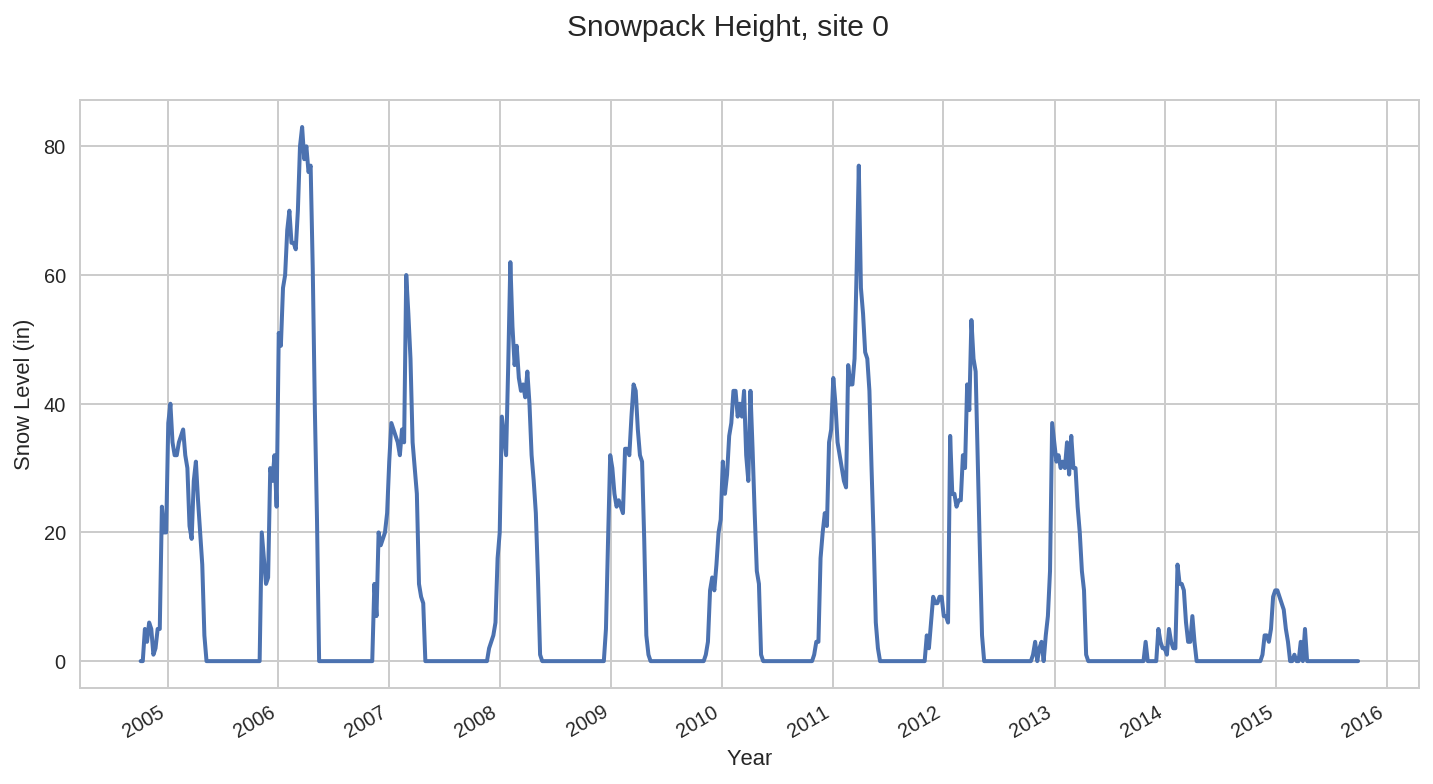

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(snowlevel_date_training_data, snowlevel_value_training_data, lw=2, label="training data")
ax.xaxis.set_major_locator(snow_loc)
ax.xaxis.set_major_formatter(snow_fmt)
ax.set_ylabel("Snow Level (in)")
ax.set_xlabel("Year")
fig.suptitle("Snowpack Height, site 0",
             fontsize=15)
#ax.text(0.99, .02,
#        "Source: Scripps Institute for Oceanography CO2 program\nhttp://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record",
#        transform=ax.transAxes,
#        horizontalalignment="right",
#        alpha=0.5)
fig.autofmt_xdate()


Stop. Model time. Colab and listen. Google's back, with a brand new edition.

In [0]:
# Local linear trend plus seasonal oscillation. Seasonal here = 1 for a year, w/52 time steps?
# Start w/local linear trend
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      #num_seasons=1,num_steps_per_season=52, observed_time_series=observed_time_series)
      num_seasons=52, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  #model = sts.Sum([trend], observed_time_series=observed_time_series)
  return model


In [17]:
tf.reset_default_graph()
snow_model = build_model(snowlevel_value_training_data)

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      snow_model,
      observed_time_series=snowlevel_value_training_data)


W0402 21:43:16.124636 140173800253312 tf_logging.py:161] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).


In [18]:
num_variational_steps = 201 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  # Draw samples from the variational posterior.
  q_samples_snow_ = sess.run({k: q.sample(50)
                             for k, q in variational_posteriors.items()})


W0402 21:43:31.824228 140173800253312 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


step 0 -ELBO 1955.7734375
step 20 -ELBO 1903.04736328125
step 40 -ELBO 1872.7049560546875
step 60 -ELBO 1864.79150390625
step 80 -ELBO 1857.717529296875
step 100 -ELBO 1856.252197265625
step 120 -ELBO 1856.0096435546875
step 140 -ELBO 1855.56982421875
step 160 -ELBO 1855.7789306640625
step 180 -ELBO 1854.6470947265625
step 200 -ELBO 1854.8570556640625


In [19]:
print("Inferred parameters:")
for param in snow_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_snow_[param.name], axis=0),
                              np.std(q_samples_snow_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 0.4411163032054901 +- 0.3940904140472412
LocalLinearTrend/_level_scale: 4.707158088684082 +- 0.1379491090774536
LocalLinearTrend/_slope_scale: 0.014102753251791 +- 0.01521275844424963
Seasonal/_drift_scale: 0.1165684312582016 +- 0.29728877544403076


In [0]:
snow_forecast_dist = tfp.sts.forecast(
    snow_model,
    observed_time_series=snowlevel_value_training_data,
    parameter_samples=q_samples_snow_,
    num_steps_forecast=num_forecast_steps)


In [0]:
num_samples=60

with tf.Session() as sess:
  snow_forecast_mean, snow_forecast_scale, snow_forecast_samples = sess.run(
      (snow_forecast_dist.mean()[..., 0],
       snow_forecast_dist.stddev()[..., 0],
       snow_forecast_dist.sample(num_samples)[..., 0]))


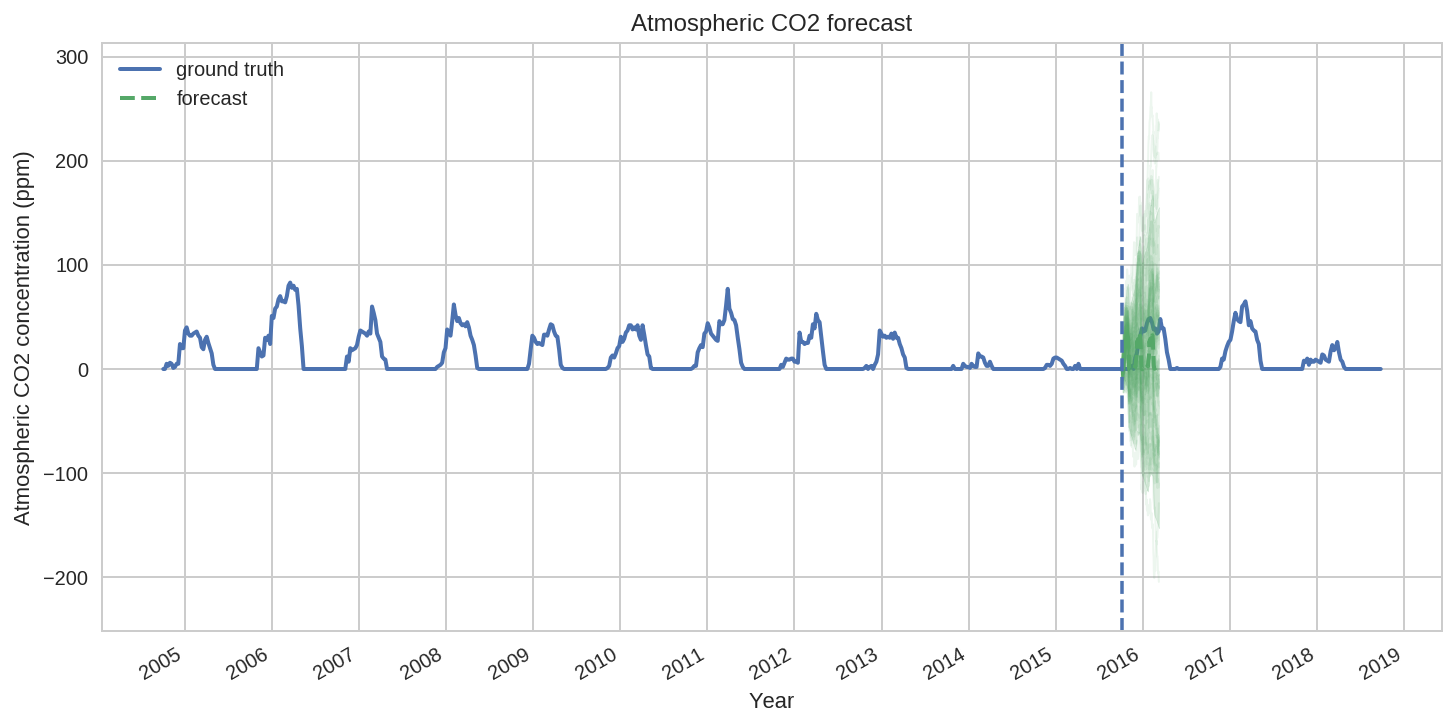

In [26]:
fig, ax = plot_forecast(
    snowlevel_date, snowlevel_value,
    snow_forecast_mean, snow_forecast_scale, snow_forecast_samples,
    x_locator=snow_loc,
    x_formatter=snow_fmt,
    title="Atmospheric CO2 forecast")
ax.axvline(snowlevel_date[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.autofmt_xdate()
